In [31]:
#https://web.tuat.ac.jp/~yamanaka/pcoms2019/Cahn-Hilliard-2d.html

%matplotlib notebook
import math
from matplotlib.widgets import Slider, Button
import numpy as np
from numpy.random import *
import matplotlib.pyplot as plt

In [32]:
nx = 71 # number of computational grids along x direction
ny = nx # number of computational grids along y direction
xx = nx - 1
yy = ny - 1

dx, dy = 2.0e-9, 2.0e-9 # spacing of computational grids [m]
c0 = 0.54 # average composition of B atom [atomic fraction]
R = 8.314 # gas constant
temp = 673 # temperature [K]
nsteps = 15000# total number of time-steps

dx_sq = dx*dx
dy_sq = dy*dy

RxT = R*temp

beta = 7.5 # for probability of accept / reject

# variables for force of repulsion between active particles
calc_forces = True
force_length_scale = 2 * 1.122462
interaction_range = 3

In [33]:
La = 21000.-9.*temp # Atom intaraction constant [J/mol]
ac = 3.0e-14 # gradient coefficient [Jm2/mol]
Da = 1.0e-04*np.exp(-30000.0/R/temp) # diffusion coefficient of A atom [m2/s]
Db = 2.0e-05*np.exp(-30000.0/R/temp) # diffusion coefficient of B atom [m2/s]

DbDa = Db/Da

print(Da)
dt = (dx*dx/Da)*0.1 # time increment [s]
cc = np.linspace(0.01, 0.99, 100);

4.693288703565294e-07


In [34]:
c = np.zeros((nx,ny)) # order parameter c at time t
c_new = np.zeros((nx,ny)) # order parameter c at time t+dt

mu_chem_c = np.zeros((nx,ny))
mu_chem_w = np.zeros((nx,ny))
mu_chem_e = np.zeros((nx,ny))
mu_chem_n = np.zeros((nx,ny))
mu_chem_s = np.zeros((nx,ny))

mu_grad_c = np.zeros((nx,ny))
mu_grad_w = np.zeros((nx,ny))
mu_grad_e = np.zeros((nx,ny))
mu_grad_n = np.zeros((nx,ny))
mu_grad_s = np.zeros((nx,ny))

mu_c = np.zeros((nx,ny))
mu_w = np.zeros((nx,ny))
mu_e = np.zeros((nx,ny))
mu_n = np.zeros((nx,ny))
mu_s = np.zeros((nx,ny))

nabla_mu = np.zeros((nx,ny))

dc2dx2 = np.zeros((nx,ny))
dc2dy2 = np.zeros((nx,ny))

mob = np.zeros((nx,ny))
dmdc = np.zeros((nx,ny))
dcdt = np.zeros((nx,ny))

bc_list_j = [0,1,ny-2, ny-1]
bc_list_i = [0,1,nx-2, nx-1]

In [35]:
def update_orderparameter(c,c_new, center_x,  center_y):
    
    # build matrix for setting multiplier on La
    k_mul = np.ones((nx,ny)) * 0.5
    
    for z in range(len(center_x)):
   
        i_base = round(center_x[z])
        j_base = round(center_y[z])

        for j in range(j_base - 5, j_base + 5):
            for i in range(i_base - 5, i_base + 5):

                j_use = j
                i_use = i

                if (j_use >= ny):
                    j_use -= ny

                if (i_use >= nx):
                    i_use -= nx

                if (j_use < 0):
                    j_use += ny

                if (i_use < 0):
                    i_use += nx

                dist_sq = (i - center_x[z])**2 + (j - center_y[z])**2

                k_mul_prop = 0.5

                if ((dist_sq > 16) and (dist_sq < 25)):
                    k_mul_prop = 1 - 0.5 * (dist_sq**0.5 - 4)
                elif dist_sq >= 25:
                    k_mul_prop = 0.5
                elif dist_sq <= 16:
                    k_mul_prop = 1

                # keep highest value
                if (k_mul_prop > k_mul[i_use,j_use]):
                     k_mul[i_use,j_use] = k_mul_prop

    # update concentrations
    
    # chemical term of the diffusion potential
    mu_chem_c[:,:] = RxT*(np.log(c[:,:])-np.log(1.0-c[:,:])) + k_mul[:,:]*La*(1.0-2.0*c[:,:])
        
    mu_chem_w[1:,:] = RxT*(np.log(c[0:-1,:])-np.log(1.0-c[0:-1,:])) + k_mul[0:-1,:]*La*(1.0-2.0*c[0:-1,:]) 
    mu_chem_w[0,:] = RxT*(np.log(c[-1,:])-np.log(1.0-c[-1,:])) + k_mul[-1,:]*La*(1.0-2.0*c[-1,:])
    
    mu_chem_e[0:-1,:] = RxT*(np.log(c[1:,:])-np.log(1.0-c[1:,:])) + k_mul[1:,:]*La*(1.0-2.0*c[1:,:])
    mu_chem_e[-1,:] = RxT*(np.log(c[0,:])-np.log(1.0-c[0,:])) + k_mul[0,:]*La*(1.0-2.0*c[0,:])
    
    mu_chem_n[:,0:-1] = RxT*(np.log(c[:,1:])-np.log(1.0-c[:,1:])) + k_mul[:,1:]*La*(1.0-2.0*c[:,1:]) 
    mu_chem_n[:,-1] = RxT*(np.log(c[:,0])-np.log(1.0-c[:,0])) + k_mul[:,0]*La*(1.0-2.0*c[:,0])
    
    mu_chem_s[:,1:] = RxT*(np.log(c[:,0:-1])-np.log(1.0-c[:,0:-1])) + k_mul[:,0:-1]*La*(1.0-2.0*c[:,0:-1])
    mu_chem_s[:,0] = RxT*(np.log(c[:,-1])-np.log(1.0-c[:,-1])) + k_mul[:,-1]*La*(1.0-2.0*c[:,-1])
    
    # gradient term of the diffusion potential
    mu_grad_c[2:-2,2:-2] = -ac*( (c[3:-1,2:-2] -2.0*c[2:-2,2:-2] +c[1:-3,2:-2] )/dx_sq + 
                                 (c[2:-2,3:-1] -2.0*c[2:-2,2:-2] +c[2:-2,1:-3] )/dy_sq )
    mu_grad_w[2:-2,2:-2] = -ac*( (c[2:-2,2:-2] -2.0*c[1:-3,2:-2] +c[0:-4,2:-2] )/dx_sq + 
                                 (c[1:-3,3:-1] -2.0*c[1:-3,2:-2] +c[1:-3,1:-3] )/dy_sq )
    mu_grad_e[2:-2,2:-2] = -ac*( (c[4:,2:-2]   -2.0*c[3:-1,2:-2] +c[2:-2,2:-2] )/dx_sq + 
                                 (c[3:-1,3:-1] -2.0*c[3:-1,2:-2] +c[3:-1,1:-3] )/dy_sq )  
    mu_grad_n[2:-2,2:-2] = -ac*( (c[3:-1,3:-1] -2.0*c[2:-2,3:-1] +c[1:-3,3:-1] )/dx_sq + 
                                 (c[2:-2,4:]   -2.0*c[2:-2,3:-1] +c[2:-2,2:-2] )/dy_sq ) 
    mu_grad_s[2:-2,2:-2] = -ac*( (c[3:-1,1:-3] -2.0*c[2:-2,1:-3] +c[1:-3,1:-3] )/dx_sq + 
                                 (c[2:-2,2:-2] -2.0*c[2:-2,1:-3] +c[2:-2,0:-4] )/dy_sq )
    
    # fill in boundary conditions on gradient matrix
    for j in bc_list_j:
        for i in range(0,nx):
            
            ip = i + 1
            im = i - 1
            jp = j + 1
            jm = j - 1
            ipp = i + 2
            imm = i - 2
            jpp = j + 2
            jmm = j - 2

            if ip > nx-1:  # periodic boundary condition
                ip = ip - nx
            if im < 0:
                im = im + nx
            if jp > ny-1:
                jp = jp - ny
            if jm < 0:
                jm = jm + ny
            if ipp > nx-1: 
                ipp = ipp - nx
            if imm < 0:
                imm = imm + nx
            if jpp > ny-1:
                jpp = jpp - ny
            if jmm < 0:
                jmm = jmm + ny
            
            cc = c[i,j] # at (i,j) "centeral point"
            ce = c[ip,j] # at (i+1.j) "eastern point"
            cw = c[im,j] # at (i-1,j) "western point"
            cs = c[i,jm] # at (i,j-1) "southern point"
            cn = c[i,jp] # at (i,j+1) "northern point"
            cse = c[ip,jm] # at (i+1, j-1)
            cne = c[ip,jp]
            csw = c[im,jm]
            cnw = c[im,jp]
            cee = c[ipp,j]  # at (i+2, j+1)
            cww = c[imm,j]
            css = c[i,jmm]
            cnn = c[i,jpp]
            
            mu_grad_c[i,j] = -ac*( (ce -2.0*cc +cw )/dx_sq + (cn  -2.0*cc +cs )/dy_sq )
            mu_grad_w[i,j] = -ac*( (cc -2.0*cw +cww)/dx_sq + (cnw -2.0*cw +csw)/dy_sq )
            mu_grad_e[i,j] = -ac*( (cee-2.0*ce +cc )/dx_sq + (cne -2.0*ce +cse)/dy_sq )  
            mu_grad_n[i,j] = -ac*( (cne-2.0*cn +cnw)/dx_sq + (cnn -2.0*cn +cc )/dy_sq ) 
            mu_grad_s[i,j] = -ac*( (cse-2.0*cs +csw)/dx_sq + (cc  -2.0*cs +css)/dy_sq ) 
            
    for j in range(2,ny-2):
        for i in bc_list_i:
            
            ip = i + 1
            im = i - 1
            jp = j + 1
            jm = j - 1
            ipp = i + 2
            imm = i - 2
            jpp = j + 2
            jmm = j - 2

            if ip > nx-1:  # periodic boundary condition
                ip = ip - nx
            if im < 0:
                im = im + nx
            if jp > ny-1:
                jp = jp - ny
            if jm < 0:
                jm = jm + ny
            if ipp > nx-1: 
                ipp = ipp - nx
            if imm < 0:
                imm = imm + nx
            if jpp > ny-1:
                jpp = jpp - ny
            if jmm < 0:
                jmm = jmm + ny
            
            cc = c[i,j] # at (i,j) "centeral point"
            ce = c[ip,j] # at (i+1.j) "eastern point"
            cw = c[im,j] # at (i-1,j) "western point"
            cs = c[i,jm] # at (i,j-1) "southern point"
            cn = c[i,jp] # at (i,j+1) "northern point"
            cse = c[ip,jm] # at (i+1, j-1)
            cne = c[ip,jp]
            csw = c[im,jm]
            cnw = c[im,jp]
            cee = c[ipp,j]  # at (i+2, j+1)
            cww = c[imm,j]
            css = c[i,jmm]
            cnn = c[i,jpp]
            
            mu_grad_c[i,j] = -ac*( (ce -2.0*cc +cw )/dx/dx + (cn  -2.0*cc +cs )/dy/dy )
            mu_grad_w[i,j] = -ac*( (cc -2.0*cw +cww)/dx/dx + (cnw -2.0*cw +csw)/dy/dy )
            mu_grad_e[i,j] = -ac*( (cee-2.0*ce +cc )/dx/dx + (cne -2.0*ce +cse)/dy/dy )  
            mu_grad_n[i,j] = -ac*( (cne-2.0*cn +cnw)/dx/dx + (cnn -2.0*cn +cc )/dy/dy ) 
            mu_grad_s[i,j] = -ac*( (cse-2.0*cs +csw)/dx/dx + (cc  -2.0*cs +css)/dy/dy ) 

            
    # add potentials            
    mu_c[:,:] = mu_chem_c[:,:] + mu_grad_c[:,:]
    mu_w[:,:] = mu_chem_w[:,:] + mu_grad_w[:,:]
    mu_e[:,:] = mu_chem_e[:,:] + mu_grad_e[:,:]
    mu_n[:,:] = mu_chem_n[:,:] + mu_grad_n[:,:] 
    mu_s[:,:] = mu_chem_s[:,:] + mu_grad_s[:,:] 
    
       
    nabla_mu[:,:] = (mu_w[:,:] -2.0*mu_c[:,:] + mu_e[:,:])/dx/dx + (mu_n[:,:] -2.0*mu_c[:,:] + mu_s[:,:])/dy/dy    
    
    dc2dx2[1:-1,:] = ((c[2:,:]-c[0:-2,:])*(mu_e[1:-1,:]-mu_w[1:-1,:]))/(4.0*dx_sq)    
    dc2dx2[0,:] = ((c[1,:]-c[-1,:])*(mu_e[0,:]-mu_w[0,:]))/(4.0*dx_sq)
    dc2dx2[-1,:] = ((c[0,:]-c[-2,:])*(mu_e[-1,:]-mu_w[-1,:]))/(4.0*dx_sq)
        
    dc2dy2[:,1:-1] = ((c[:,2:]-c[:,0:-2])*(mu_n[:,1:-1]-mu_s[:,1:-1]))/(4.0*dy_sq)
    dc2dy2[:,0] = ((c[:,-1]-c[:,1])*(mu_n[:,0]-mu_s[:,0]))/(4.0*dy_sq)
    dc2dy2[:,-1] = ((c[:,-2]-c[:,0])*(mu_n[:,-1]-mu_s[:,-1]))/(4.0*dy_sq)
    
    mob[:,:] = (Da/RxT)*(c[:,:]+DbDa*(1.0-c[:,:]))*c[:,:]*(1.0-c[:,:]) 
    dmdc[:,:] = (Da/RxT)*((1.0-DbDa)*c[:,:]*(1.0-c[:,:])+(c[:,:]+DbDa*(1.0-c[:,:]))*(1.0-2.0*c[:,:])) 

    dcdt[:,:] = mob[:,:]*nabla_mu[:,:] + dmdc[:,:]*(dc2dx2[:,:] + dc2dy2[:,:]) # right-hand side of Cahn-Hilliard equation
    c_new[:,:] = c[:,:] + dcdt[:,:] *dt # update order parameter c 

In [36]:
c = np.zeros((nx,ny)) # zero-clear
c_new = np.zeros((nx,ny)) # zero clear

c = c0 + np.random.rand(nx, ny)*0.01 - np.random.rand(nx, ny)*0.01

circ = np.linspace(0, 2 * np.pi, 200);
circ_x = np.linspace(0, 2 * np.pi, 200);
circ_y = np.linspace(0, 2 * np.pi, 200);
circ_d_x = np.linspace(0, 2 * np.pi, 200);
circ_d_y = np.linspace(0, 2 * np.pi, 200);

for i in range(len(circ)):
    circ_x[i] = math.cos(circ[i]) * 5
    circ_y[i] = math.sin(circ[i]) * 5


In [37]:
def force_calc(i_index, j_index, x_offset, y_offset):
    
    d_vector_x = c_x[j_index] - (c_x[i_index] - x_offset)
    d_vector_y = c_y[j_index] - (c_y[i_index] - y_offset)
    dist_f = (d_vector_x**2 + d_vector_y**2)**0.5

    if (dist_f < force_length_scale):
        f_mag = 0.15 * ((force_length_scale - dist_f)/force_length_scale)**0.5
        
        forces_x[i_index] += -f_mag * d_vector_x
        forces_y[i_index] += -f_mag * d_vector_y

        forces_x[j_index] += f_mag * d_vector_x
        forces_y[j_index] += f_mag * d_vector_y

        def_move[i_index] = 1
        def_move[j_index] = 1

#     elif ((dist_f >= force_length_scale) and (dist_f < (force_length_scale + 0.5))):
#         forces_x[i_index] += -0.15 * (1 - 2* (dist_f - force_length_scale)) * d_vector_x
#         forces_y[i_index] += -0.15 * (1 - 2* (dist_f - force_length_scale)) * d_vector_y

#         forces_x[j_index] += 0.15 * (1 - 2* (dist_f - force_length_scale)) * d_vector_x
#         forces_y[j_index] += 0.15 * (1 - 2* (dist_f - force_length_scale)) * d_vector_y 
    

In [38]:
def Determine_Proper_Seperation_2D(Particle_X, Particle_Y, Test_X, Test_Y, Min_Distance):

    Diff_X = Particle_X - Test_X
    Diff_Y = Particle_Y - Test_Y

    Temp_Dist = (pow((Diff_X), 2) + pow((Diff_Y), 2))**0.5

    if (Temp_Dist < Min_Distance):
        return False

    return True
    
X_Offsets_2D = [0, 70, -70, 0, 0, 70, 70, -70, -70]
Y_Offsets_2D = [0, 0, 0, 70, -70, 70, -70, 70, -70]

In [39]:
c_x = []
c_y = []

x_centers = []
y_centers = []

Num_Colloids = 300

# for i in range(0,13):
#     for j in range(0,13):
#         c_x.append(5 + 5 * i)
#         c_y.append(5 + 5 * j)
        
#         x_centers.append([5 + 5 * i])
#         y_centers.append([5 + 5 * j])

#c_x = [30, 40, 30, 40]
#c_y = [30, 40, 40, 30]

#x_centers = [[30],[40],[30],[40]]
#y_centers = [[30],[40],[40],[30]]

# c_x = [30]
# c_y = [30]

# x_centers = [[30]]
# y_centers = [[30]]

for i in range(0,Num_Colloids):
        
    Good_Position = False;

    while (not Good_Position):
        Temp_X = np.random.rand()*70.0
        Temp_Y = np.random.rand()*70.0

        Good_Position = True

        for j in range(0,i):
            Current_X = c_x[j]
            Current_Y = c_y[j]

            for k in range(0,9):
                Good_Position &= Determine_Proper_Seperation_2D(Current_X, Current_Y,
                                (Temp_X + X_Offsets_2D[k]), (Temp_Y + Y_Offsets_2D[k]), interaction_range)
        

    c_x.append(Temp_X);
    c_y.append(Temp_Y);
    
    x_centers.append([Temp_X])
    y_centers.append([Temp_Y])


c_all = []
c_all.append(np.copy(c))

fails = 0

for nstep in range(1,nsteps+1):
    update_orderparameter(c,c_new, c_x, c_y)
    c[:,:] = c_new[:,:] # swap c at time t and c at time t+dt
    
    forces_x = [0] * len(c_x)
    forces_y = [0] * len(c_x)
    
    def_move = [0] * len(c_x)
    
    Corner_list_LU = []
    Corner_list_RU = []
    Corner_list_LD = []
    Corner_list_RD = []

    Edge_list_L = []
    Edge_list_R = []
    Edge_list_U = []
    Edge_list_D = []
    
    if calc_forces == True:
        
        for i in range(0, len(c_x)):
               
            if (c_x[i] < interaction_range):

                if (c_y[i] < interaction_range):
                    Corner_list_LD.append(i)

                elif (c_y[i] > (yy - interaction_range)):
                    Corner_list_LU.append(i)

                else:
                    Edge_list_L.append(i)

            elif (c_x[i] > (xx - interaction_range)):

                if (c_y[i] < interaction_range):
                    Corner_list_RD.append(i)

                elif (c_y[i] > (yy - interaction_range)):
                    Corner_list_RU.append(i)

                else:
                    Edge_list_R.append(i)

            elif (c_y[i] < interaction_range):
                Edge_list_D.append(i)

            elif (c_y[i] > (yy - interaction_range)):
                Edge_list_U.append(i)
        
        for i in range(0, len(c_x)-1):
            for j in range(i+1, len(c_x)):               
                force_calc(i, j, 0, 0)
                    
        for i in range(0, len(Edge_list_R)):
            for j in range(0, len(Edge_list_L)):             
                force_calc(Edge_list_R[i], Edge_list_L[j], xx, 0)
                    
        for i in range(0, len(Edge_list_U)):
            for j in range(0, len(Edge_list_D)):             
                force_calc(Edge_list_U[i], Edge_list_D[j], 0, yy)
                    
        for i in range(0, len(Corner_list_RU)):
            for j in range(0, len(Corner_list_LD)):             
                force_calc(Corner_list_RU[i], Corner_list_LD[j], xx, yy)
                
        for i in range(0, len(Corner_list_LU)):
            for j in range(0, len(Corner_list_RD)):             
                force_calc(Corner_list_LU[i], Corner_list_RD[j], -xx, yy)
                
        for i in range(0, len(Corner_list_RU)):
            for j in range(0, len(Corner_list_RD)):             
                force_calc(Corner_list_RU[i], Corner_list_RD[j], 0, yy)

        for i in range(0, len(Corner_list_LU)):
            for j in range(0, len(Corner_list_LD)):             
                force_calc(Corner_list_LU[i], Corner_list_LD[j], 0, yy)

        for i in range(0, len(Corner_list_RU)):
            for j in range(0, len(Corner_list_LU)):             
                force_calc(Corner_list_RU[i], Corner_list_LU[j], xx, 0)

        for i in range(0, len(Corner_list_RD)):
            for j in range(0, len(Corner_list_LD)):             
                force_calc(Corner_list_RD[i], Corner_list_LD[j], xx, 0)

    for z in range(len(c_x)):
        v_x = np.random.normal()*0.2
        v_y = np.random.normal()*0.2
        
        v_x += forces_x[z]
        v_y += forces_y[z]
        
        c_diff = c[round(c_x[z]),round(c_y[z])]

        c_x_p = c_x[z] + v_x
        c_y_p = c_y[z] + v_y

        if (c_x_p > xx):
            c_x_p -=xx
        if (c_y_p > yy):
            c_y_p -=yy

        if (c_x_p < 0):
            c_x_p += xx
        if (c_y_p < 0):
            c_y_p += yy 
            
        # move to new location depending on concentration
        
        test = np.random.rand()
        c_diff = c[round(c_x[z]),round(c_y[z])] - c[round(c_x_p),round(c_y_p)]
        
        if (c[round(c_x_p),round(c_y_p)] < 0.45):
            c_x[z] = c_x_p
            c_y[z] = c_y_p 
        elif (test < np.exp(beta * c_diff)):
            c_x[z] = c_x_p
            c_y[z] = c_y_p      
        else:
            fails += 1

    if nstep % 5 == 0:
        c_all.append(np.copy(c))
        
        for z in range(len(c_x)):            
            x_centers[z].append(c_x[z])
            y_centers[z].append(c_y[z])
        
print(fails)


240146


<IPython.core.display.Javascript object>


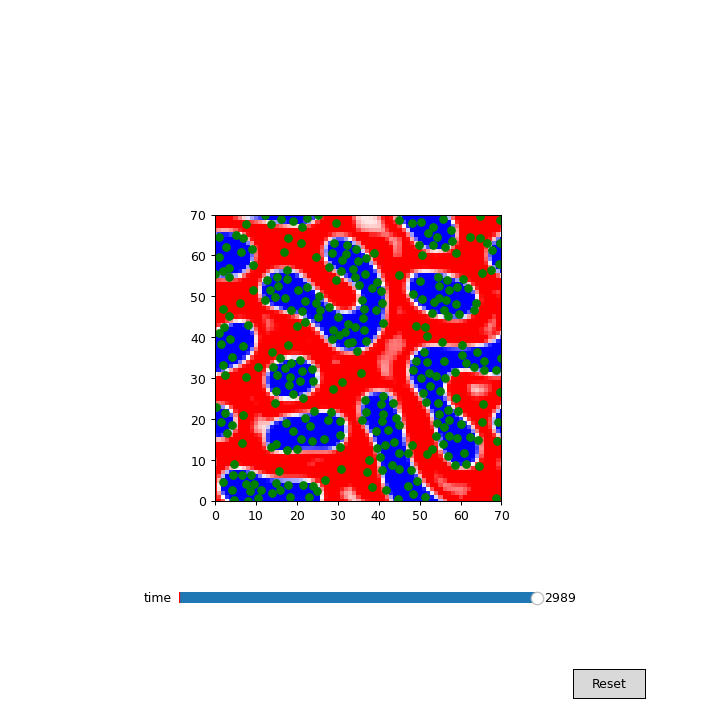

In [40]:
plt.rcParams["figure.figsize"] = (8,8)          
            
fig, ax = plt.subplots()
            
ax.imshow(c_all[0], cmap='bwr', vmin = 0.3, vmax = 0.8)

for z in range(len(c_x)):
    ax.plot(y_centers[z][0], x_centers[z][0], 'go')
    
#     for i in range(len(circ)):
#         circ_d_x[i] = x_centers[z][0] + circ_x[i]
#         circ_d_y[i] = y_centers[z][0] + circ_y[i]

#     ax.plot(circ_d_y, circ_d_x, 'g.', markersize=1)

#adjust the main plot to make room for the sliders
fig.subplots_adjust(left=0.3, bottom=0.3, right=0.7, top=0.7)

# Make a horizontal slider to control P3 X.
axfreq = fig.add_axes([0.25, 0.15, 0.5, 0.03])
p3x_slider = Slider(
    ax=axfreq,
    label='time',
    valmin=0,
    valmax=2995,
    valinit=0,
)

# The function to be called anytime a slider's value changes
def update(val):
    ax.clear()
    ax.imshow(c_all[round(p3x_slider.val)], cmap='bwr', vmin = 0.3, vmax = 0.8)

    
    for z in range(len(c_x)):
        
        ax.plot(y_centers[z][round(p3x_slider.val)], x_centers[z][round(p3x_slider.val)], 'go')
        
#         for i in range(len(circ)):
#             circ_d_x[i] = x_centers[z][round(p3x_slider.val)] + circ_x[i]
#             circ_d_y[i] = y_centers[z][round(p3x_slider.val)] + circ_y[i]
            
#             if (circ_d_x[i] > 70):
#                 circ_d_x[i] -=70
#             if (circ_d_y[i] > 70):
#                 circ_d_y[i] -=70

#             if (circ_d_x[i] < 0):
#                 circ_d_x[i] += 70
#             if (circ_d_y[i] < 0):
#                 circ_d_y[i] += 70 

#         ax.plot(circ_d_y, circ_d_x, 'g.', markersize=1)
    
    ax.set_xlim([0, nx - 1])
    ax.set_ylim([0, ny - 1])
    
    fig.canvas.draw_idle()

# register the update function with each slider
p3x_slider.on_changed(update)

# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = fig.add_axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')

def reset(event):
    p3x_slider.reset()
    
button.on_clicked(reset)

plt.show()

In [60]:
for z in range(0, 2000):
    print(np.sum(c_all[z])," ")
    

2595.498210452428  
2595.4497422304757  
2595.4487399542445  
2595.448465757683  
2595.448367190871  
2595.4483158766798  
2595.4482922632133  
2595.448298491327  
2595.4482799822226  
2595.4482392017726  
2595.4482119696377  
2595.44821882052  
2595.448203877235  
2595.448183845403  
2595.4482065350326  
2595.4482078702804  
2595.4482027572017  
2595.4482185218503  
2595.4482502393726  
2595.448283239581  
2595.4483103953103  
2595.448348388937  
2595.4483632668525  
2595.4483132870073  
2595.448346337659  
2595.4483561731436  
2595.4482906014214  
2595.4482854055086  
2595.448282929013  
2595.448286938653  
2595.448320467255  
2595.4483340134652  
2595.4483655618897  
2595.4483928822806  
2595.448440633507  
2595.4484762238053  
2595.4484801884587  
2595.4485070145356  
2595.4485058779323  
2595.4485638793435  
2595.448597023851  
2595.448594201563  
2595.4486149750433  
2595.4486459825685  
2595.448693840175  
2595.448725384243  
2595.4487126179074  
2595.448729122816  
2595.4487421

In [55]:
for z in range(0, 2000):
    print(np.amax(c_all[z])," ")

0.5399193937348316  
0.5359543217612097  
0.5352886796676067  
0.5351165634523802  
0.535066660343573  
0.5350375293218959  
0.5350221873751239  
0.5350172003597723  
0.5350208712625726  
0.5350322340129517  
0.5350506020499558  
0.5350753934984306  
0.5351313594265564  
0.5351971572167229  
0.5352640906270736  
0.5353324696073672  
0.5354025508307787  
0.5354745465529414  
0.5355486328230501  
0.5356249566543202  
0.535703642045816  
0.5357847949151033  
0.5358685070771327  
0.5359548594256062  
0.5360439244657774  
0.5361357683285288  
0.5362304523734878  
0.5363280344680792  
0.5364285700113974  
0.536532112757  
0.5366387154769166  
0.5367484304999054  
0.5368613101497873  
0.5369774071041177  
0.5370967746891407  
0.5372194671236403  
0.5373467962453324  
0.5375060201507964  
0.5376691844788257  
0.5378363759084767  
0.5380076828041072  
0.5381831953508918  
0.5383630056801078  
0.5385472079849485  
0.5387358986277706  
0.5389291762397511  
0.5391271418139237  
0.5393298987925315 